# Goal of the notebook:
```
CARTPOLE PROBLEM: Deep Policy methods: Actor-critic method
```

* A state in cartpole problem is defined with 4 values - cart position, cart velocity, pole angle, pole angular velocity.

* Action space - Two actions - left and right.

* Instead of having two different steps for value baselining and taking actions, directly assigning values to the actions themselves and choosing the appropriate action.

In policy based methods, we have probabilities (log probabilities are used to be practical) and there is an advantage term multiplied by some learning rate.

In Actor-critic methods, instead of just using returns values as the advantage function, we use returns and values.

So, although we will not be value-baselining seperately, we need a value estimate of actions in the given state. We do this using a seperate Critic network (Value) along with Actor (Policy).

```
Critic : Works out how good our current situation is
Actor: Acts
```

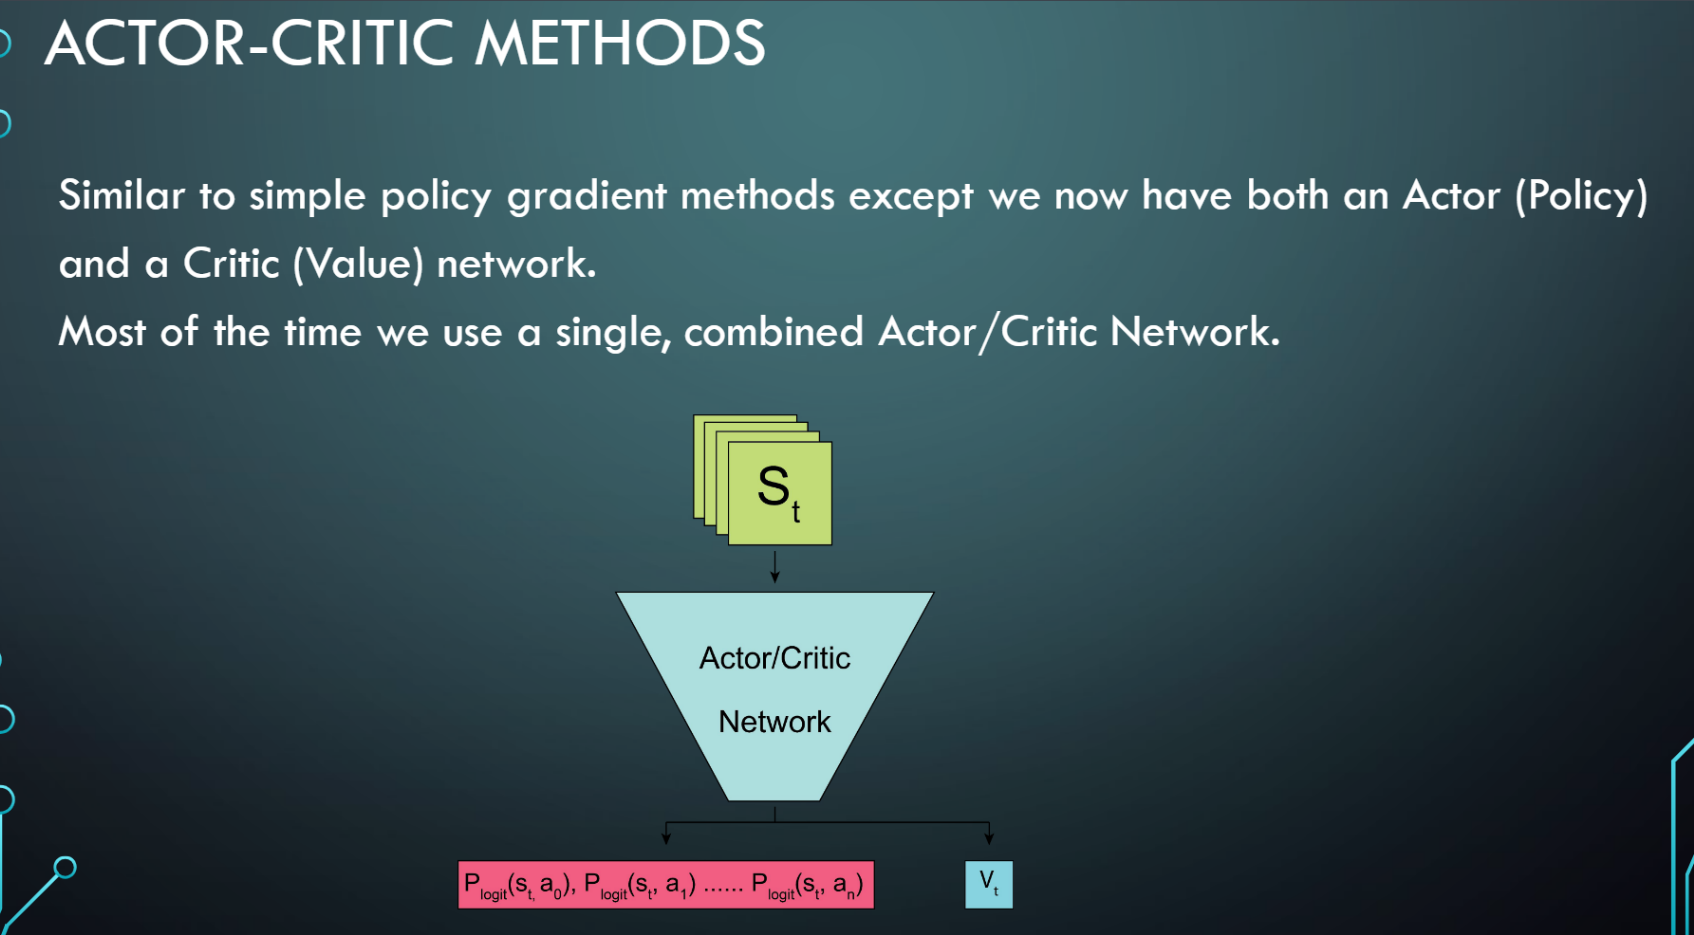

We could have a seperate Actor network, however, it is common to share most of the parameters of actor-critic networks and just have different heads.

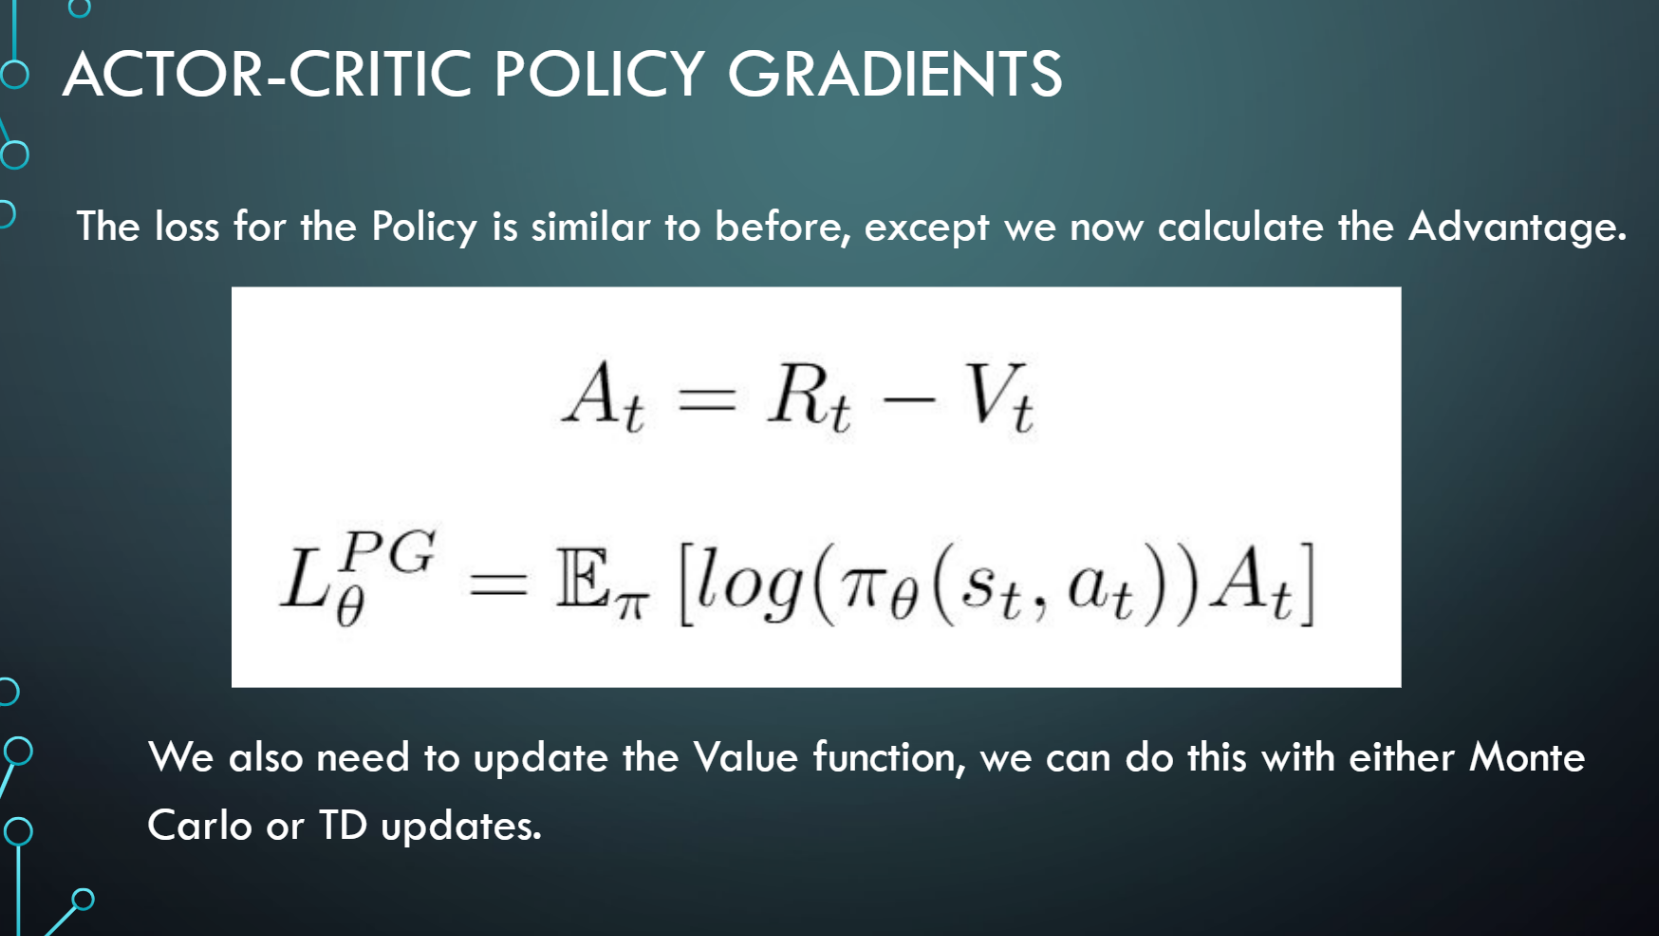

This advantage function tells us how better are our returns better than the average values. So, is our situation better than the average situation?

# Imports

In [17]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Configuring the Cart-Pole environment from OpenAI Gymnasium.

In [18]:
env_name = 'CartPole-v0'
env = gym.make(env_name)

# Defining the neural network

Here, we are having two different MLPs for actor and critic networks. However, we don't necessarily need them to be two seperate ones.

In [19]:
class RL(nn.Module):
    def __init__(self, action_num=2, hidden_size=256):
        super(RL, self).__init__()
        self.actor_fc1 = nn.Linear(4, hidden_size) # 4 values that are needed to define the state
        self.actor_fc2 = nn.Linear(hidden_size, action_num) # To output two values in relation to the two actions associated with the given state information

        self.critic_fc1 = nn.Linear(4, hidden_size)
        self.critic_fc2 = nn.Linear(hidden_size, 1) # We need to take in state information and estimate a "value" to determine how good our current situation is

    def forward(self, x):
        ax = F.relu(self.actor_fc1(x))
        logits = self.actor_fc2(ax) # Outputs two action prob values associated with each state
        dist = Categorical(logits=logits)
        # We are creating a categorical object
        # This takes in input logits and apply softmax over them giving us a probability distribution
        # We are using this instead of explicitly using torch.softmax() on our own as
        # This gives us some extra functionality like sample() and makes it easy to compute log probs.

        cx = F.relu(self.critic_fc1(x))
        value = self.critic_fc2(cx) # Value
        return dist, value


# Test agent

The testing code that uses the trained policy network to make inferences on a single trajectory.

* Also used to compute the score in a given trajectory by computing total rewards accumulated through out the episode.

In [20]:
def calc_returns(rewards, gamma=0.99):
  returns = []
  delta = 0
  for reward in rewards[::-1]: #Rewards reverse iteration with slicing notation with [start,stop,step] with step=-1
    delta = reward + gamma * delta
    returns.insert(0,delta) # As reverse iterations, adding on forward
  return returns


def test_agent():
    done = False
    total_reward = 0
    observation = torch.FloatTensor(env.reset()).unsqueeze(0) # Initial state

    with torch.no_grad():
        while not done: # done when the episode is complete
            dist,_ = rl_model(observation) # Send the state as input to get action distribution

            # Not following epsilon-greedy
            # Taking random action, also while respecting respective action probabilities
            # Good as takes the action with high action mostly, but some times still takes other
            # Good for exploring new states and values
            action = dist.sample().cpu().item()
            observation, reward, done, info = env.step(action) # step in Gym is taking the action at current state
            # observation -> next state upon taking respective action
            # reward # done -> done with the episode? # info -> extra information
            observation = torch.FloatTensor(observation).unsqueeze(0) # converting into a torch tensor and unsqueeze to inclue bs dimension
            total_reward += reward

    return total_reward

In [21]:
rl_model = RL() # Model instantiation
lr = 1e-3
optimizer = optim.Adam(rl_model.parameters(), lr=lr)

In [22]:
max_steps = 100000 # Much higher number of max_steps
rollouts = 0
step = 0
score_logger = []

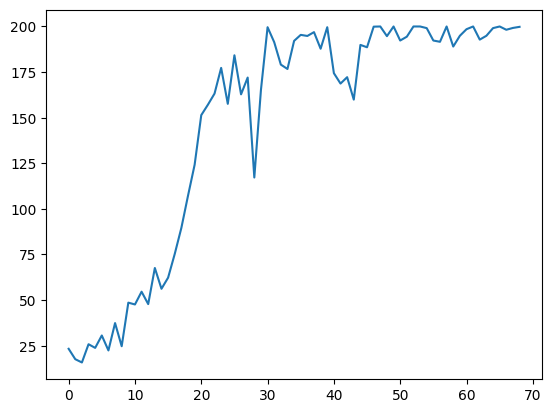

In [23]:
while step < max_steps: # step means the total number of steps across all episodes.
    observation = torch.FloatTensor(env.reset()).unsqueeze(0) # Resetting when starting an episode
    done = False
    rewards = []
    log_probs = []
    values = []

    while not done: # While episode is not done
        dist,value = rl_model(observation) # Passing the state to the model
        action = dist.sample() # Taking a sample action from the distribution
        log_prob = dist.log_prob(action.unsqueeze(0)) # Computing the log probability of the action

        observation, reward, done, info = env.step(action.cpu().item()) # Taking the action in the gym environment

        observation = torch.FloatTensor(observation).unsqueeze(0)
        reward = torch.FloatTensor([reward]).unsqueeze(0)

        rewards.append(reward)
        log_probs.append(log_prob)
        values.append(value)

        step += 1

    returns = calc_returns(rewards)

    returns = torch.cat(returns,1)
    log_probs = torch.cat(log_probs,1)
    values = torch.cat(values,1)

    # Loss function computation of the entire agent

    ## Advantage term ##
    advantage = (returns-values).detach()
    action_loss = -(log_probs * advantage).mean()
    critic_loss = (returns - values).pow(2).mean() # MSE loss b/w predicted values during rollouts and current returns computed
    agent_loss = action_loss + critic_loss

    # optimizer
    optimizer.zero_grad()
    agent_loss.backward()
    optimizer.step()

    if rollouts % 10 == 0: # Update is happening every ten episodes to reduce computational overhead
            new_lr = ((max_steps - step)/max_steps) * lr
            # lr decreases with time as steps increase

            # updating learning rate in optimizer
            optimizer.param_groups[0]["lr"] = new_lr

            # Calculating score using test_agent() that accumulates rewards and taking in average of 10 such test runs
            # test_agent() just uses exploitation
            score_logger.append(np.mean([test_agent() for _ in range(10)]))

            clear_output(True)
            plt.plot(score_logger)
            plt.show()

    rollouts+=1

env.close()

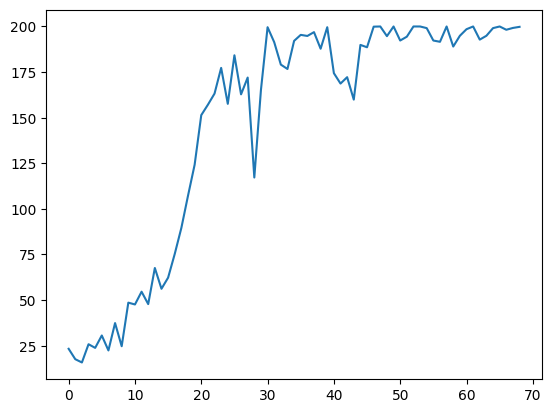

In [24]:
plt.plot(score_logger)

Instead of the above implementation of the loss function in actor-critic method, where we should wait until an episode is complete to compute the returns and then use them in the advantage function,
* We can also implement the time-difference method.
* Instead of computing returns at the end of the trajectory, we can estimate a value at the given time step.
* We can use the temporal difference term as the loss function
* advantage = (reward + gamma * next_value - value).detach()
* current value is the output of the critic network at the current time step. Then we take action and we get to the next state. This next state information can be sent to the model to compute values in the next state and we can use both of these values to compute the loss function.
* This can give us much more stable and converging result
